# Exercises: physics-informed neural network

Exercise on the implementation of physics-informed neural network. 

Author: Stefano Pagani <stefano.pagani@polimi.it>.

Date: 2024

Course: Mathematical and numerical foundations of scientific machine learning.

Example adapted from this [notebook](https://colab.research.google.com/drive/1qBrbgevkSBqqYc8bOPiaoJG1MBrBrluN?usp=share_link). 


Let us consider the problem

\begin{aligned}
  & -\nu \Delta u = -2(x^2+y^2)  \,, \quad (x,y) \in [-1,1] \times [-1,1]\,,\\
  & u(x,-1) = u(x,1) = -x^2 \,, \quad -1 < x < 1\,, \\
  & u(-1,y) = u(1,y) = -y^2 \,, \quad -1 < y < 1\,, \\
\end{aligned}

where $\nu$ is unknown. We consider the PINN framework for solving this state/parameter estimation.

Task: find an architecture and optmization setting that perform well in reconstucting the field $u(x,y)$

In [35]:
# import required libraries

import tensorflow as tf
import numpy as np
import scipy.io
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#!pip -q install pyDOE
from pyDOE import lhs  # for latin hypercube sampling


# Solution

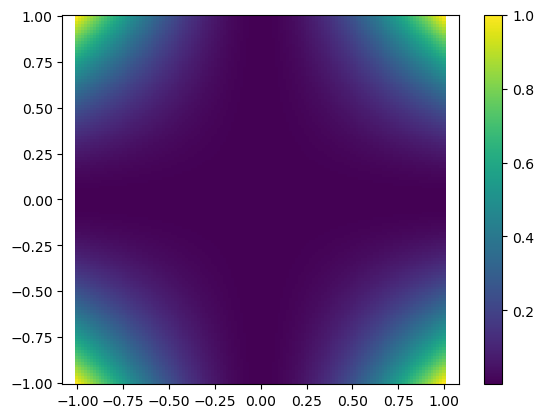

In [36]:
# plot exact solution
nu = 1.0 # diffusion parameter

# define grid for sampling the exact solution
N_h = 128
ux = np.linspace(-1.0,1.0,N_h)
uy = np.linspace (-1.0,1.0,N_h)

# sampling loop:
u_true = np.zeros([N_h,N_h])
for i in range(N_h):
    u_true[:,i] = (ux[i]**2)*(uy**2)

X_plot,Y_plot = np.meshgrid(ux,uy)
plt.pcolor(X_plot, Y_plot, u_true)
plt.axis('equal')
plt.colorbar()



In [37]:
# flatten grid and solution
X,Y = np.meshgrid(ux,uy)
X_flat = tf.convert_to_tensor(np.hstack((X.flatten()[:,None],Y.flatten()[:,None])),dtype=tf.float64)
u_flat = u_true.T.flatten()

In [38]:
np.shape(u_true)

(128, 128)

In [39]:

# PINN loss function
def loss(xcl,ycl,xmeas,ymeas,umeas,param):
    u_pred = PINN(tf.concat([xmeas,ymeas],1))
    r_pred   = r_PINN(xcl,ycl,param)

    # loss components
    mse_meas = tf.reduce_mean(tf.pow(u_pred-umeas,2))
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2))

    return mse_r+mse_meas 

# neural network weight gradients
@tf.function
def grad(model,xcl,ycl,xmeas,ymeas,umeas,param):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,ycl,xmeas,ymeas,umeas,param)
        grads = tape.gradient(loss_value,model.trainable_variables)
        grad_param = tape.gradient(loss_value,param)
    return loss_value, grads, grad_param

In [40]:
# collocation points
Ncl = 2000
X = lhs(2,Ncl)
xcl = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
ycl = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,1],dtype=tf.float64),axis=-1)
X_coll = tf.concat([xcl,ycl],1)

# measrement data

Nmeas = 20
X = lhs(2,Nmeas)
xmeas = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
ymeas = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,1],dtype=tf.float64),axis=-1)
umeas = (xmeas**2)*(ymeas**2) #+ tf.random.normal(shape=tf.shape(xmeas),mean=0,stddev=0.01,dtype=tf.float64)

# # Dirichlet boundary condition points
# Nb = 500
# X = lhs(1,Nb)
# ylb = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
# xlb = -1.0*tf.ones(tf.shape(ylb),dtype=tf.float64)
# ulb = (xlb**2)*(ylb**2)
# X_lb = tf.concat([xlb,ylb],1)

# X = lhs(1,Nb)
# yub = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
# xub = 1.0*tf.ones(tf.shape(yub),dtype=tf.float64)
# uub = (xub**2)*(yub**2)
# X_ub = tf.concat([xub,yub],1)

# Y = lhs(1,Nb)
# xleft = tf.expand_dims(tf.cast(-1.0+(2.0)*Y[:,0],dtype=tf.float64),axis=-1)
# yleft = -1.0*tf.ones(tf.shape(xleft),dtype=tf.float64)
# uleft = (xleft**2)*(yleft**2)
# X_left = tf.concat([xleft,yleft],1)

# Y = lhs(1,Nb)
# xright = tf.expand_dims(tf.cast(-1.0+(2.0)*Y[:,0],dtype=tf.float64),axis=-1)
# yright = 1.0*tf.ones(tf.shape(xright),dtype=tf.float64)
# uright = (xright**2)*(yright**2)
# X_right = tf.concat([xright,yright],1)



In [41]:
# training loop

# initialize new instance of NN
PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='tanh', input_shape=(2,),kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(32, activation='tanh',kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(1,activation=None,kernel_initializer="glorot_normal",dtype=tf.float64)
])



In [42]:

# residual computation based on AD
@tf.function
def r_PINN(x,y,param):
    u    = PINN(tf.concat([x,y], 1))
    u_x  = tf.gradients(u,x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_y  = tf.gradients(u,y)[0]
    u_yy = tf.gradients(u_y, y)[0]
    return - tf.math.exp(param) * (u_xx + u_yy) + 2.0*( tf.pow(x,2) + tf.pow(y,2) )

# define a tensorflow variable
param = tf.Variable( 0.1 , trainable=True , dtype=tf.float64)

# Adam optimizer
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003,beta_1=0.99)

for iter in range(20000):

  # compute gradients using AD
  loss_value,grads,grad_param = grad(PINN,xcl,ycl,xmeas,ymeas,umeas,param)

  # update neural network weights
  tf_optimizer.apply_gradients(zip(grads+[grad_param],PINN.trainable_variables+[param]))

  # display intermediate results
  if ((iter+1) % 200 == 0):
    print('iter =  '+str(iter+1))
    print('loss = {:.4f}'.format(loss_value))
    print('parameter estimate = {:.4f}'.format(np.exp(param.numpy())))
    PINN_flat = PINN(X_flat)
    err = np.linalg.norm(u_flat-PINN_flat[:,-1],2)/np.linalg.norm(u_flat,2)
    print('L2 error: %.4e' % (err))
    

iter =  200
loss = 0.8652
parameter estimate = 1.4713
L2 error: 5.3166e-01
iter =  400
loss = 0.1708
parameter estimate = 1.9525
L2 error: 7.8914e-01
iter =  600
loss = 0.0572
parameter estimate = 2.2929
L2 error: 7.9958e-01
iter =  800
loss = 0.0292
parameter estimate = 2.4274
L2 error: 7.7352e-01
iter =  1000
loss = 0.0209
parameter estimate = 2.4767
L2 error: 7.9559e-01
iter =  1200
loss = 0.0177
parameter estimate = 2.4667
L2 error: 7.9750e-01
iter =  1400
loss = 0.0165
parameter estimate = 2.4039
L2 error: 8.1536e-01
iter =  1600
loss = 0.0156
parameter estimate = 2.3148
L2 error: 8.1844e-01
iter =  1800
loss = 0.0148
parameter estimate = 2.2163
L2 error: 8.0838e-01
iter =  2000
loss = 0.0139
parameter estimate = 2.1109
L2 error: 7.8862e-01
iter =  2200
loss = 0.0131
parameter estimate = 1.9918
L2 error: 7.6379e-01
iter =  2400
loss = 0.0122
parameter estimate = 1.8614
L2 error: 7.3776e-01
iter =  2600
loss = 0.0112
parameter estimate = 1.7225
L2 error: 7.0845e-01
iter =  2800
los

Text(0.5, 1.0, 'L2 error = 0.0269')

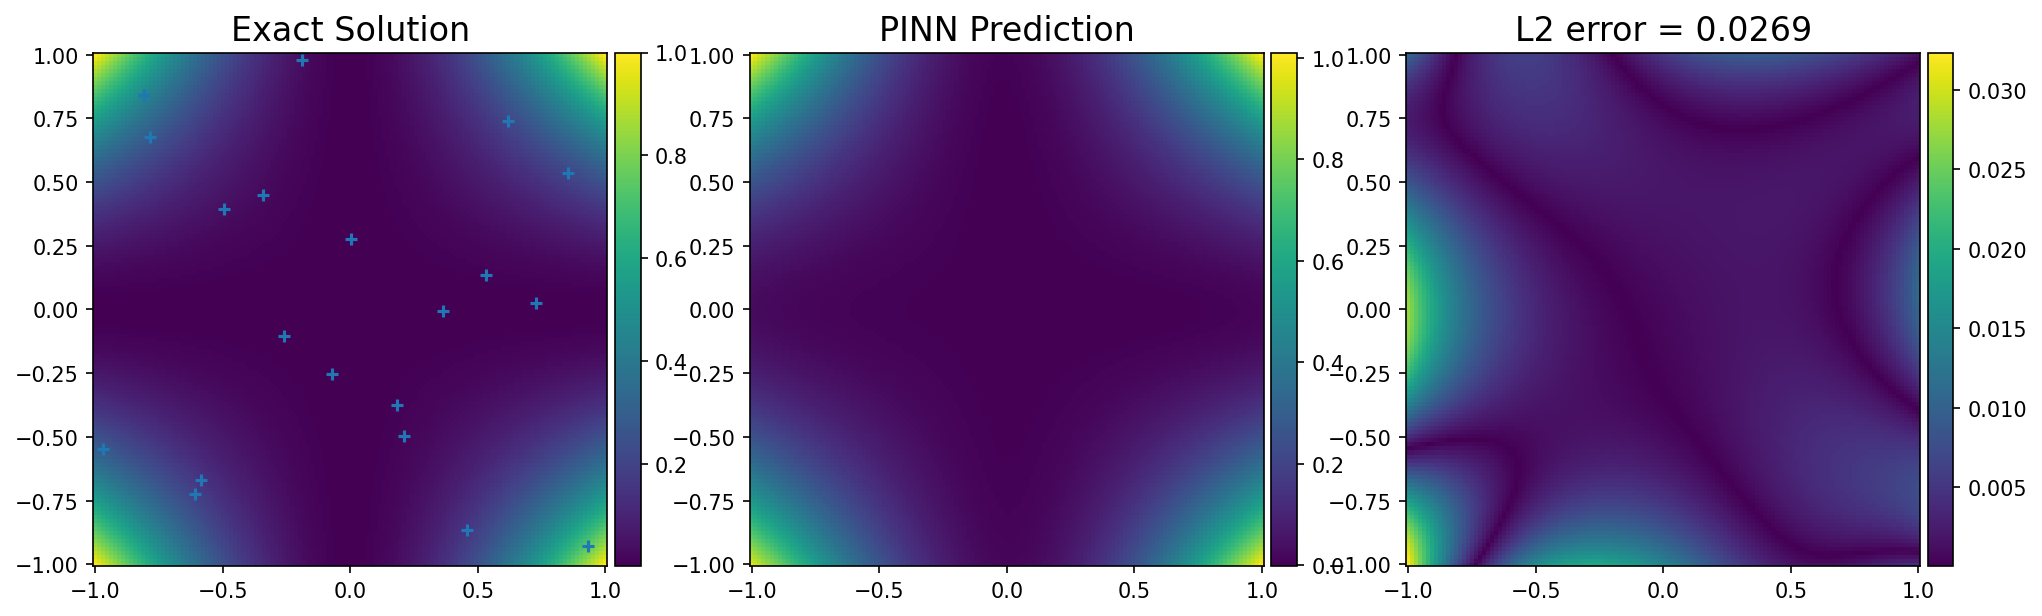

In [43]:
#Display results

fig = plt.figure(figsize=(16,9),dpi=150)
#fig = plt.figure()
#fig.subplots_adjust(wspace=0.3)
plt.style.use('default')
ax = fig.add_subplot(1,3,1)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, u_true)
plt.scatter(xmeas.numpy(),ymeas.numpy(),marker='+')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
#ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_title('Exact Solution',fontsize=16)

ax = fig.add_subplot(1,3,2)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.reshape(PINN_flat,(N_h,N_h)))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('PINN Prediction'.format(err),fontsize=16)

ax = fig.add_subplot(1,3,3)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.abs( np.reshape(PINN_flat,(N_h,N_h)) -u_true ) )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('L2 error = {:.4f}'.format(err),fontsize=16)